___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg" width="300px" height="180px" />


# <font color= #bbc28d> **Stock Exchange Forecasting** </font>
#### <font color= #2E9AFE> `Lab 3 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 20/11/2025.

___

<p style="text-align:right;"> Image retrieved from: https://www.retailtouchpoints.com/wp-content/uploads/2020/09/Walmart-Redesign-exterior.jpg</p>

# <font color= #bbc28d> **Introduction** </font>

Stock forecasting is one of the most important fields in finance, since **accurate predictions allow for better and more precise decision-making capabilites where investments are involved**. In this sense, data science integration via time series analysis and modeling are essential.

Intending to make use of some popular neural network models and their relevance to finance, this notebook covers the use of **Recurrent Neural Networks (RNN's) for stock exchange forecasting**, focusing on Walmart's stocks over the past 5 years. 

Two baseline models (SMA and ARIMA) will be compared to two RNN's models (RNN and LSTM) to evaluate performance and prediction power. The objective is to identify the best approach and manner to carry out predictions in the field of stock forecasting.

----

In [1]:
# === IMPORTS ===

# Generales
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Redes Neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Time Series Analysis
import mplfinance as mpf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Deal with warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# <font color= #bbc28d> **Data Loading** </font>

Using the library _yfinance_, the stocks of Walmart in the last five years were downloaded on 14/nov/2025. Open, High, Low, Close and Volume (OHLCV) fields were selected for the download, which will be the features used for model training and evaluation.

In [77]:
# # RUN THIS CODE ONLY ONE TIME
# start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')          # Gets last 5 years of data
# end_date = datetime.now().strftime('%Y-%m-%d')

# # Download Walmart prices
# wmt = yf.download('WMT', start=start_date, end=end_date, progress=True)

# # Flatten columns to get only data
# wmt.columns = wmt.columns.get_level_values(0)

# # Keep OHLCV data
# wmt = wmt[['Open', 'High', 'Low', 'Close', 'Volume']]

# # Save to csv
# wmt.to_csv('data/walmart_stocks.csv', index=True)

In [2]:
# Read data
df = pd.read_csv('data/walmart_stocks.csv')
df['Date'] = pd.to_datetime(df['Date'])             # Convert Date column to date type
df = df.set_index('Date')                           # Make the Date column the index
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-16,46.804732,47.697108,46.416065,47.398613,34560300
2020-11-17,46.795404,47.647361,46.384971,46.444050,42711600
2020-11-18,46.596410,47.159198,46.344554,46.356991,24936900
2020-11-19,46.472042,47.401731,46.428512,47.299126,18590700
2020-11-20,47.003731,47.498113,46.580864,46.714565,21937200


# <font color= #bbc28d> **Data Visualization** </font>

For starters, let's take a quick look at the data: 

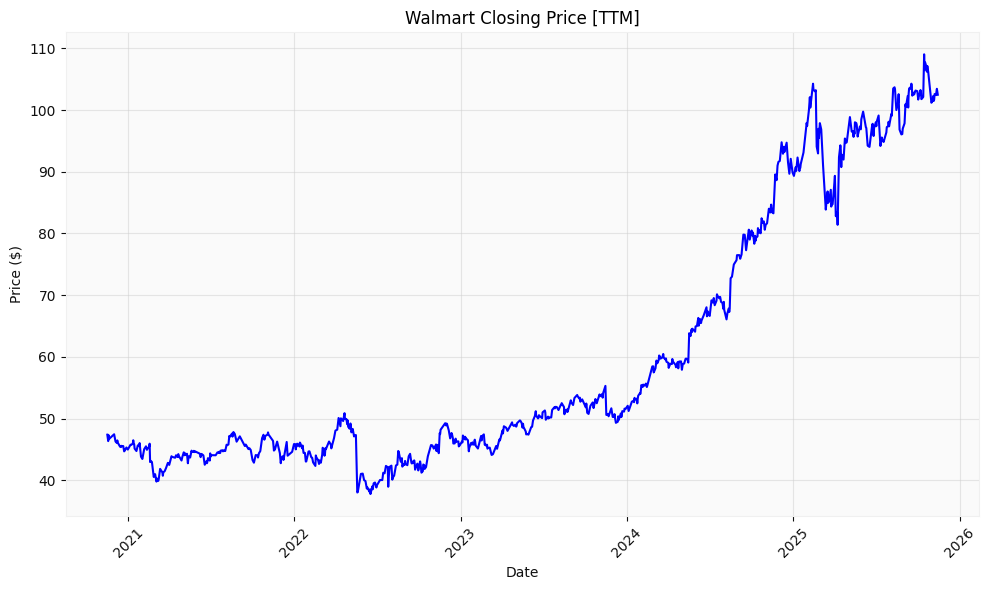

In [79]:
# Initialize an empty figure
plt.figure(figsize=(10, 6))
plt.grid(alpha=0.5)

# Plot the closing prices
plt.plot(
    df.index,
    df["Close"],
    color="blue",
    linewidth=1.5
)

# Set the plot title and axis labels
plt.title(f"Walmart Closing Price [TTM]")
plt.xlabel("Date")
plt.ylabel("Price ($)")

# Finish constructing the plot
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

As observed in the chart, Walmart's stock had been quite stable until around 2023, experiencing a sharp increase the following years.

<br>

Let's take a closer look at Walmart's stock behaviour via OHLCV data analysis with candlesticks charts, which showcase the relationship between OHLCV prices:

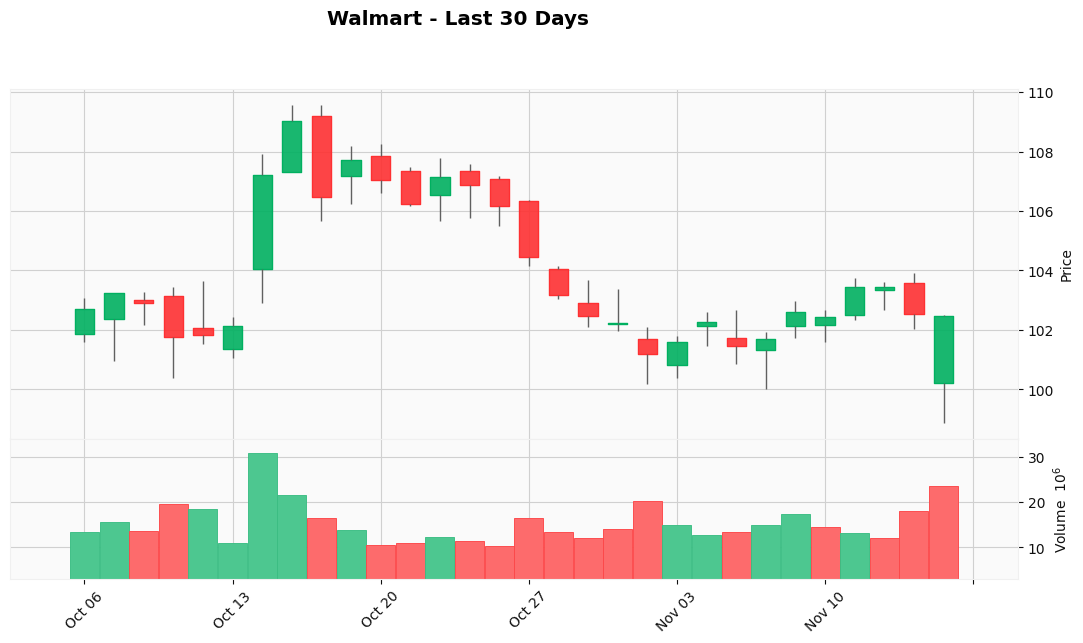

In [80]:
# Select last 30 days of data 
df_latest = df.tail(30)

# plot the latest data, thereby creating a "zoomed in" version of the plot
mpf.plot(
    df_latest,
    type="candle",
    style="yahoo",
    figsize=(14, 7),
    volume=True,
    title=f"Walmart - Last 30 Days"
)

In the last 30 days, Walmart's stock has been experiencing quite a decrease in value, with varying prices. Mostly of which result in worse closing prices at the end of the day.

# <font color= #bbc28d> **Preprocessing** </font>

Although there doesn't seem to be any missing data from the visualizations provided, let's further evaluate if the data contains any NaN values:

In [81]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Since there are no NaN values, the data is good to go through further preprocessing techniques. Firstly, let's apply a train-test-split to avoid data leakage:

In [3]:
# Establish test size
train_size = 0.8
split_index = int(len(df) * train_size)

# Train-Test-Split
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f"Train Size: {len(train_df)}")
print(f"Train Dates: {train_df.index.min()} to {train_df.index.max()} \n")
print(f"Test Size: {len(test_df)}")
print(f"Test Dates: {test_df.index.min()} to {test_df.index.max()}")

Train Size: 1004
Train Dates: 2020-11-16 00:00:00 to 2024-11-12 00:00:00 

Test Size: 252
Test Dates: 2024-11-13 00:00:00 to 2025-11-14 00:00:00


After applying a train-test-split, scaling the data is recommended, due to the high variance across time. And since data is derived from a time series, the best option is using a MinMaxScaler:

In [4]:
scaler = MinMaxScaler()

# Scale training data
train_df_scaled = scaler.fit_transform(train_df[['Close']])           # Keep only closing values
train_df_scaled = pd.Series(train_df_scaled.flatten(), index=train_df.index)

# Scale testing data
test_df_scaled = scaler.transform(test_df[['Close']])          
test_df_scaled = pd.Series(test_df_scaled.flatten(), index=test_df.index)

# <font color= #bbc28d> **Baseline** </font>

The baseline models selected to be compared against RNN architectures are _**Moving Average**_ and _**ARIMA**_. The results of these models will be compared to the RNN architectures proposed later in this notebook.

## <font color= #66b0b0> &ensp; • **Simple Moving Average (SMA)** </font>

Simple Moving Average (SMA) is a model that **calculates the average of a set of data within a specified time frame, shifting with each new data** to provide a clearer view of the overall trend. It helps smooth out data fluctuations and reveals trends over time, however, it does not consider significant fluctuations in data, since all points are weighted equally. 

Due to the simplicity of the SMA model, no further preprocessing of data is needed besides the already applied MinMaxScaler.

In [19]:
# SMA model
def sma_forecast(train_df, test_df, window_size):
    history = list(train_df)                # Start with training values
    preds = []
    
    for i in test_df:
        # Calculate simple moving average
        if len(history) >= window_size:
            pred = np.mean(history[-window_size:])
        else:
            pred = np.mean(history)
        
        preds.append(pred)
        history.append(i)                   # Update with actual test value
    
    return np.array(preds)

Since SMA works with a window size, and as observed in the visualization, stock prices tend to vary quite a lot, a smaller window of 10 days will be used for predictions.

In [20]:
window_size = 10

# Run the model
preds_scaled = sma_forecast(train_df_scaled, test_df_scaled, window_size)

# Re-scale the predictions, since they're in the MinMaxScale scale
preds_original = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()

sma_results = pd.DataFrame({
    'Actual': test_df['Close'].values,
    'SMA_Predicted': preds_original}, 
    index=test_df.index)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(sma_results['Actual'], sma_results['SMA_Predicted']))
mae = mean_absolute_error(sma_results['Actual'], sma_results['SMA_Predicted'])
mape = mean_absolute_percentage_error(sma_results['Actual'], sma_results['SMA_Predicted'])

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape *100:.2f}%')

RMSE: 2.8835
MAE: 2.2514
MAPE: 2.36%


After re-scaling the data for metric evaluation, it's clear that the fitted model performed quite good. It should be noted, however, that the precision of the model is in no short part because of the small window selected.

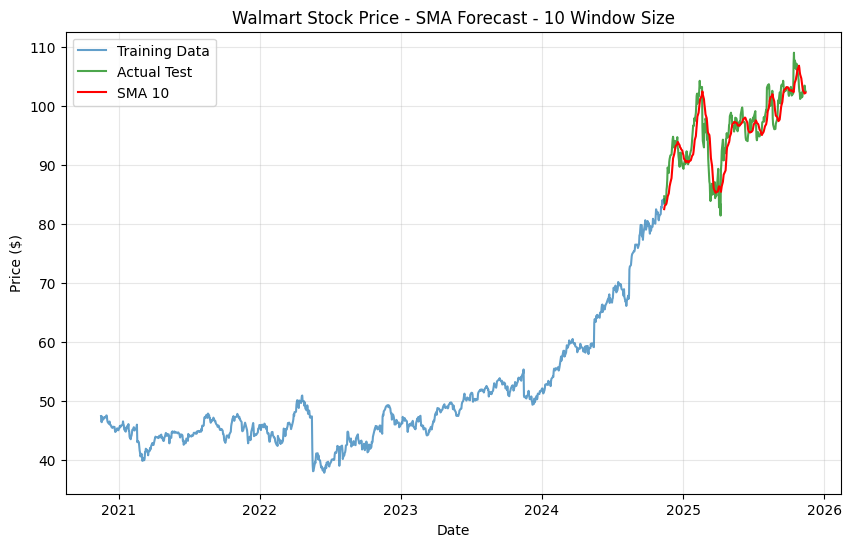

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(sma_results.index, sma_results['SMA_Predicted'], label=f'SMA {window_size}', color='red')

plt.title(f"Walmart Stock Price - SMA Forecast - {window_size} Window Size")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## <font color= #66b0b0> &ensp; • **ARIMA** </font> 

We define ranges of ARIMA parameters (p, d, q) to try different model configurations. This allows us to systematically explore which combination works best for our data.

In [87]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

results = []

We perform walk-forward cross-validation on the train+validation set:
- Fold division: The train+validation set is split into 5 consecutive folds.

- Expanding window: For each fold, the model is trained on all data up to that fold, simulating real-world forecasting.

- Validation prediction: The model predicts the next fold (the validation window) using only past data.

- RMSE calculation: The error between predictions and actual values is computed for each fold.

- Average RMSE: The mean RMSE across all folds measures how well each ARIMA configuration generalizes over time.

In [88]:
# Use only Close column
train_df_arima = train_df[['Close']]
test_df_arima = test_df[['Close']]

# Params
n_folds = 5
fold_size = len(train_df_arima) // n_folds
fold_ends = [(i + 1) * fold_size for i in range(n_folds)]

# Outputs
arima_results = []
target = 'Close'

for p in p_values:
    for d in d_values:
        for q in q_values:

            order = (p, d, q)
            rmse_list = []

            # Evaluar el modelo en múltiples folds
            try:
                for end in fold_ends:
                    # Train folds
                    train_fold = train_df_arima.iloc[:end][target].values
                    
                    # Validation folds
                    val_start = end
                    val_end   = min(end + fold_size, len(train_df_arima))
                    val_fold  = train_df_arima.iloc[val_start:val_end][target].values

                    if len(val_fold) == 0:
                        continue

                    model = ARIMA(train_fold, order=order)
                    model_fit = model.fit()

                    pred = model_fit.forecast(steps=len(val_fold))

                    rmse = np.sqrt(mean_squared_error(val_fold, pred))
                    rmse_list.append(rmse)

                if rmse_list:
                    avg_rmse = np.mean(rmse_list)
                    arima_results.append((order, avg_rmse))
                    print(f"ARIMA{order} -> AVERAGE RMSE = {avg_rmse:.4f}")

            except Exception as e:
                print(f"ARIMA{order} failed: {e}")

ARIMA(0, 0, 0) -> AVERAGE RMSE = 13.5665
ARIMA(0, 0, 1) -> AVERAGE RMSE = 12.9666
ARIMA(0, 0, 2) -> AVERAGE RMSE = 12.4406
ARIMA(0, 0, 3) -> AVERAGE RMSE = 11.9476
ARIMA(0, 1, 0) -> AVERAGE RMSE = 6.1668
ARIMA(0, 1, 1) -> AVERAGE RMSE = 6.1820
ARIMA(0, 1, 2) -> AVERAGE RMSE = 6.1903
ARIMA(0, 1, 3) -> AVERAGE RMSE = 6.1874
ARIMA(0, 2, 0) -> AVERAGE RMSE = 39.1896
ARIMA(0, 2, 1) -> AVERAGE RMSE = 6.6396
ARIMA(0, 2, 2) -> AVERAGE RMSE = 6.8363
ARIMA(0, 2, 3) -> AVERAGE RMSE = 6.8008
ARIMA(1, 0, 0) -> AVERAGE RMSE = 6.4639
ARIMA(1, 0, 1) -> AVERAGE RMSE = 6.4948
ARIMA(1, 0, 2) -> AVERAGE RMSE = 6.4848
ARIMA(1, 0, 3) -> AVERAGE RMSE = 6.4813
ARIMA(1, 1, 0) -> AVERAGE RMSE = 6.1841
ARIMA(1, 1, 1) -> AVERAGE RMSE = 6.1899
ARIMA(1, 1, 2) -> AVERAGE RMSE = 6.1921
ARIMA(1, 1, 3) -> AVERAGE RMSE = 6.1853
ARIMA(1, 2, 0) -> AVERAGE RMSE = 21.2512
ARIMA(1, 2, 1) -> AVERAGE RMSE = 6.8267
ARIMA(1, 2, 2) -> AVERAGE RMSE = 6.8262
ARIMA(1, 2, 3) -> AVERAGE RMSE = 6.8328
ARIMA(2, 0, 0) -> AVERAGE RMSE = 6

We select the ARIMA model with the lowest average RMSE from the walk-forward validation. This model is considered the most accurate for forecasting.

In [89]:
results_sorted = sorted(arima_results, key=lambda x: x[1])
best_order, best_rmse = results_sorted[0]

print(f"Best ARIMA: {best_order} with average RMSE = {best_rmse:.4f}")

Best ARIMA: (3, 2, 3) with average RMSE = 5.9478


We retrain the selected ARIMA model on the entire train+validation and predict stock prices in the test set:

In [90]:
# Train final model on Close prices
best_model = ARIMA(train_df_arima['Close'].values, order=best_order).fit()

# Forecast test set
pred_test = best_model.forecast(steps=len(test_df_arima))

# Actual test values
y_true = test_df_arima['Close'].values

# Metrics
rmse_test = np.sqrt(mean_squared_error(y_true, pred_test))
mae_test  = mean_absolute_error(y_true, pred_test)
mape = mean_absolute_percentage_error(y_true, pred_test)

print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f'MAPE: {mape *100:.2f}%')

RMSE: 5.7109
MAE: 4.8270
MAPE: 5.05%


We plot the train+validation series, the actual test data, and the ARIMA predictions to visually assess how well the model captures trends and changes in the stock prices.

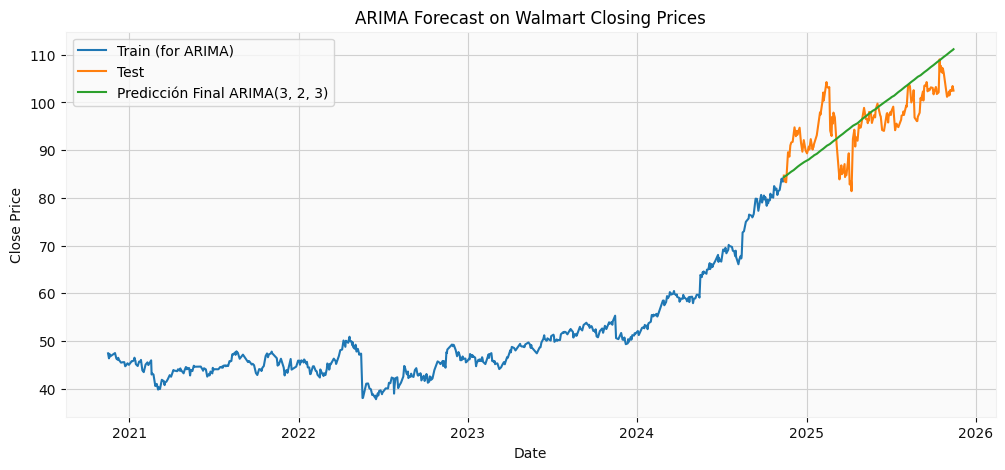

In [91]:
plt.figure(figsize=(12,5))
plt.plot(train_df_arima.index, train_df_arima['Close'], label="Train (for ARIMA)")
plt.plot(test_df_arima.index, test_df_arima['Close'], label="Test")
pred_series = pd.Series(pred_test, index=test_df_arima.index)
plt.plot(pred_series.index, pred_series.values, label=f"Predicción Final ARIMA{best_order}")

plt.legend()
plt.title("ARIMA Forecast on Walmart Closing Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# <font color= #bbc28d> **Modeling** </font>

## <font color= #66b0b0> &ensp; • **Vanilla RNN** </font>
A **vanilla RNN** is the **simplest** form of a recurrent neural network, designed to process sequential data by using feedback loops to maintain an internal memory called a `"hidden state"`. It applies the same weights at each step of the sequence to update the hidden state based on the current input and the previous state, allowing it to capture short-term dependencies.

In [33]:
# Scale the whole dataframe features
scaler = MinMaxScaler()

# Scale training data
X_train_scaled = scaler.fit_transform(train_df)           
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=train_df.columns)

# Scale testing data
X_test_scaled = scaler.transform(test_df)          
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=test_df.columns)

This code transforms the time series into sequences for an RNN. For each point, it takes the previous lookback steps as input X and the next horizon step(s) of the first column (e.g., 'Close') as target y. The window slides across the dataset to generate many input-output pairs:

In [34]:
def create_sequences(df, lookback=30, horizon=1):
    X, y = [], []
    data = df.values
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon, 0])  # predecimos la primera columna, por ejemplo 'Close'
    return np.array(X), np.array(y)

lookback = 60
horizon = 1

X_train, y_train = create_sequences(X_train_scaled, lookback, horizon)
X_test, y_test   = create_sequences(X_test_scaled, lookback, horizon)

To be able to use them with torch, we have to convert them to tensors:

In [35]:
# Convertirlos a tensores
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

The RNN reads a sequence of past values, like the last 30 days of stock prices, and remembers patterns in the data. After processing the entire sequence, it uses only the last memory (hidden state) to predict the next value. The prediction is compared to the actual value using MSE loss, and the model updates itself with the Adam optimizer to improve future predictions.

In [36]:
# Definir el vanilla RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # tomar la última salida
        return out

input_size = X_train.shape[2]  # número de features
model = RNNModel(input_size=input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train our RNN model over a number of epochs, in this cae 50, and for each epoch the model processes the training sequences to generate predictions and calculate its MSE updating its weights using Adam to get better results.

After it finishes iterating, we save the final weights of the model to just load them to make predictions:.

Epoch 10/50, Train Loss: 0.000154, RMSE: 0.012414
Epoch 20/50, Train Loss: 0.000153, RMSE: 0.012384
Epoch 30/50, Train Loss: 0.000153, RMSE: 0.012354
Epoch 40/50, Train Loss: 0.000152, RMSE: 0.012325
Epoch 50/50, Train Loss: 0.000151, RMSE: 0.012296


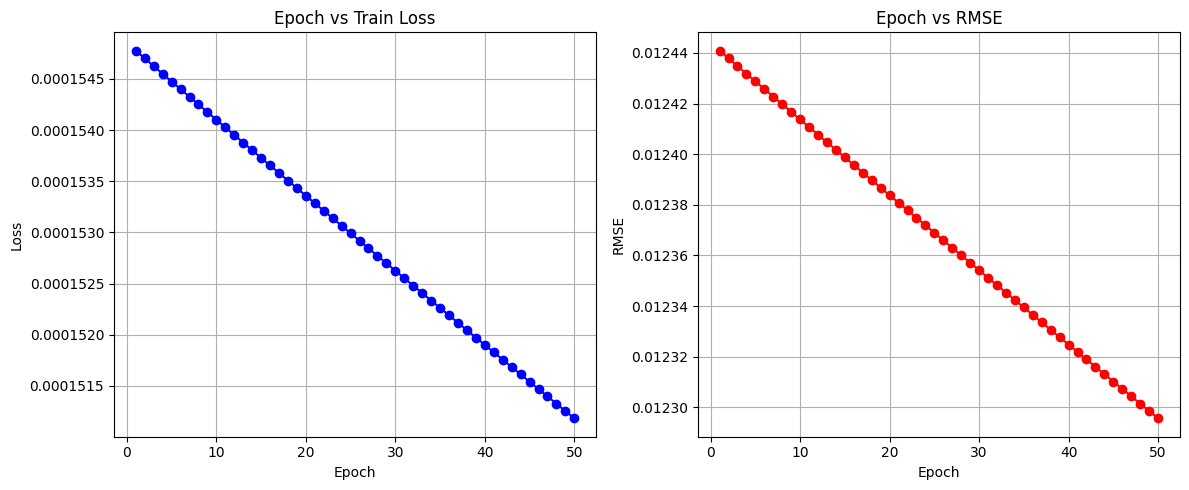

In [65]:
# Definir los parámetros
epochs = 50
torch.manual_seed(16)
train_losses = []
train_rmses = []

# Iterar por cada época y calcular su loss
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Guardar loss
    train_losses.append(loss.item())
    
    # Calcular RMSE
    rmse = torch.sqrt(loss).item()
    train_rmses.append(rmse)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.6f}, RMSE: {rmse:.6f}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), "rnn_model_scaled.pth")

# Graficar Epoch vs Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o', color='blue')
plt.title("Epoch vs Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Graficar Epoch vs RMSE
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_rmses, marker='o', color='red')
plt.title("Epoch vs RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()

Now that we vae trained our RNN we evaluate theRNN on the test set, generate predictions without gradients, and convert both predictions and true values back to the original scale for the 'Close' price while also calcutaing its performance metrics:

In [66]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test).numpy()

# Inverse scaling para la primera columna [Close]
y_test_df = pd.DataFrame(y_test.numpy(), columns=[X_train_scaled.columns[0]])
test_pred_df = pd.DataFrame(test_pred, columns=[X_train_scaled.columns[0]])

y_test_inv = scaler.inverse_transform(pd.concat([y_test_df, pd.DataFrame(np.zeros((y_test_df.shape[0], X_train_scaled.shape[1]-1)))], axis=1))[:,0]
test_pred_inv = scaler.inverse_transform(pd.concat([test_pred_df, pd.DataFrame(np.zeros((test_pred_df.shape[0], X_train_scaled.shape[1]-1)))], axis=1))[:,0]

# Calcular las métricas
rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
mae = mean_absolute_error(y_test_inv, test_pred_inv)
mape = np.mean(np.abs((y_test_inv - test_pred_inv) / y_test_inv)) * 100

print(f"RMSE: {rmse:.4f} \nMAE: {mae:.4f} \nMAPE: {mape:.2f}%")

RMSE: 2.5808 
MAE: 2.2858 
MAPE: 2.31%


We can plot the predicted vs the real values just to have a visualization on how the look compared to the real data, for that we will have to re.convert the data that the RNN gives back to a df compatible with our original data:

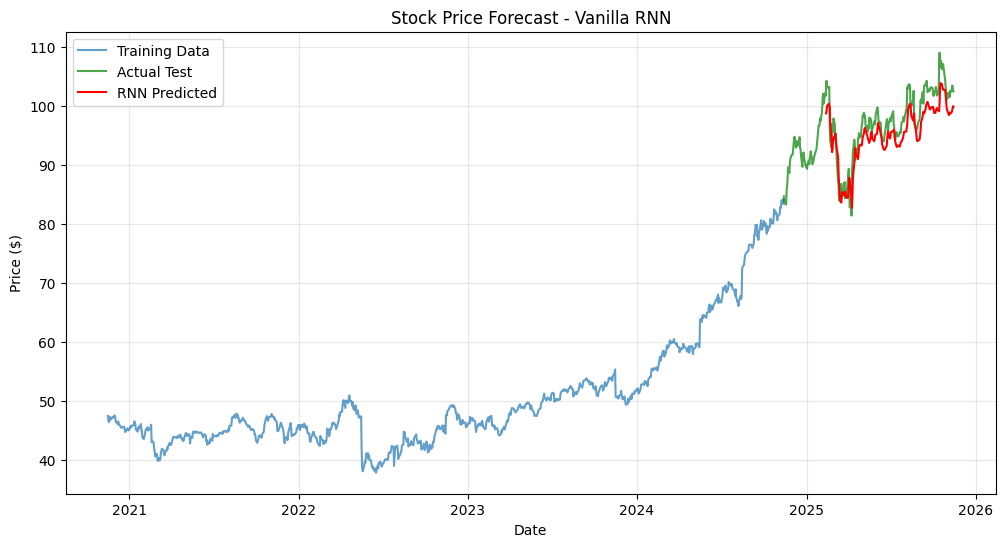

In [67]:
# Definir variables 
sequence_length = lookback          # Número de pasos anteriores que usamos como entrada
prediction_horizon = horizon       # Número de pasos hacia adelante que queremos predecir

# Crear un dataframe para almacenar los resultados
# No hay datos para sequence_length + prediction_horizon - 1
rnn_results = test_df.iloc[sequence_length + prediction_horizon - 1:].copy()

# Agregar las predicciones de la RNN como una nueva columna
rnn_results['RNN_Predicted'] = test_pred_inv.flatten()

# Plotear verdaderos vs predichos
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(rnn_results.index, rnn_results['RNN_Predicted'], label='RNN Predicted', color='red')
plt.title("Stock Price Forecast - Vanilla RNN")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Now, we are going to do a residual analysis of the predicted data

Text(0.5, 1.0, 'ACF')

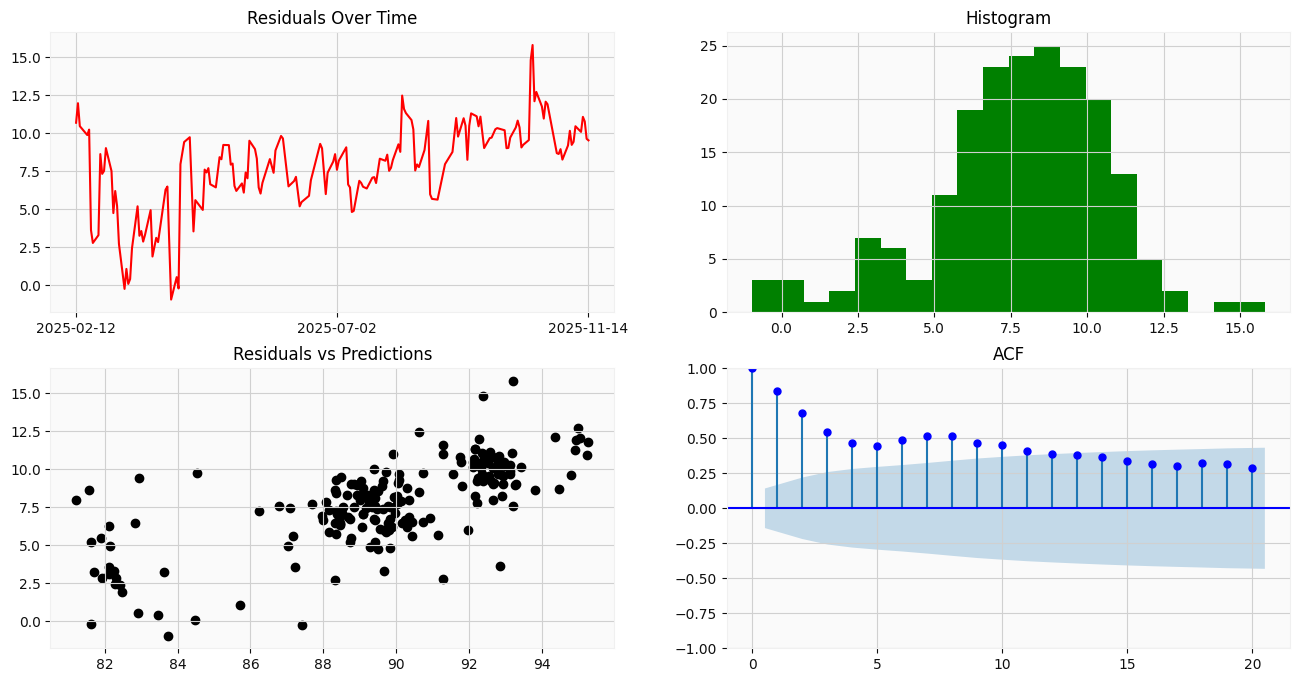

In [99]:
# Calculating residuals
rnn_results['RNN_Residuals'] = rnn_results['Close'] - rnn_results['RNN_Predicted']

fig, axes = plt.subplots(2,2, figsize=(16,8))

axes[0,0].plot(rnn_results.index, rnn_results['RNN_Residuals'], color='red')
axes[0,0].set_title('Residuals Over Time')
graph_1_ticks = [rnn_results.index[0], rnn_results.index[len(rnn_results)//2], rnn_results.index[-1]]
axes[0,0].set_xticks(graph_1_ticks)

axes[0,1].hist(rnn_results['RNN_Residuals'], bins=20, color='green')
axes[0,1].set_title('Histogram')

axes[1,0].scatter(rnn_results['RNN_Predicted'], rnn_results['RNN_Residuals'], color='black')
axes[1,0].set_title('Residuals vs Predictions')

plot_acf(rnn_results['RNN_Residuals'], lags=20, ax=axes[1,1], color='blue')
axes[1,1].set_title('ACF')

We can see that the RNN does a pretty good job at predicting values, and if we increased the number of epochs we could raise it's value even more, however, vanilla RNNs **struggle with long-term dependencies** due to the vanishing gradient problem, which causes them to "forget" information from earlier in the sequence. 

This can be seen in the residual analysis as well, especially in the ACF chart. Here we can see that the residuals do have a specific structure, and that our data has a trend that the model forgot about halfway through the predictions. 

LSTM and GRU are able to address the vanishing gradient problem more effectively than vanilla RNNs, making them a better choice for processing long sequences. So let's try a LSTM model to compare them.

## <font color= #66b0b0> &ensp; • **LSTM** </font>

Long Short-Term Memory (LSTM) models are a type of RNN that excel in time series forecasting. LSTMs are known for **remembering information for long periods**, since they were **tailored to deal with the vanishing gradient problem**. This issue arises when gradients become too small during backpropagation, to the point of making the learning of the model almost negligible due to small weight updates.

LSTMs function by **processing entire sequences of data** without treating each point in the sequence independently. Rather, they **retain useful information about previous data in the sequence to help in processing new points**. Because of this characteristic, we're going to run back the preprocessing applied, to now take into account all of the OHLCV features.

In [5]:
# Scale the whole dataframe features
scaler_all_features = MinMaxScaler()

# Scale training data
X_train_scaled = scaler_all_features.fit_transform(train_df)           
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=train_df.columns)

# Scale testing data
X_test_scaled = scaler_all_features.transform(test_df)          
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=test_df.columns)

After scaling the data now considering all dataframe features (OHLVC), a sequence length and prediction horizon will be established for LSTM. The sequence lenght is going to be equal to 60 days, while the prediction horizon will be 1 day.

In [6]:
# Constants
sequence_length = 60  # sliding window
prediction_horizon = 1  # predicting next day

# Convert to sequences
def create_sequences(data, seq_length, pred_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_horizon + 1):
        X.append(data.iloc[i:i+seq_length])
        y.append(data.iloc[i+seq_length+pred_horizon-1]['Close'])  # Output is only the Closing price
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train_scaled, sequence_length, prediction_horizon)
X_test, y_test = create_sequences(X_test_scaled, sequence_length, prediction_horizon)

Afterwards, the data has to be correctly loaded into PyTorch, which means converting the data to tensors:

In [7]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

Now we're ready to construct the LSTM model. For this, the following hyperparameters were selected:

- **Hidden Size:** 100
- **Number of Layers:** 1
- **Batch Size:** 64
- **Number of Epochs:** 50
- **Learning Rate:** 0.001
- **Optimizer:** Adam 
- **Seed:** 1

In [8]:
# Hyperparameters
hidden_size = 100
num_layers = 1
batch_size = 64
num_epochs = 50
learning_rate = 0.001
torch.manual_seed(1)

# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last time step
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
model = LSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Training

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Save the trained model
torch.save(model, "lstm_full_model.pth")

# Prediction
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

Epoch [10/50], Loss: 0.027549
Epoch [20/50], Loss: 0.006665
Epoch [30/50], Loss: 0.003507
Epoch [40/50], Loss: 0.001116
Epoch [50/50], Loss: 0.000977


Epoch 10/50, Train Loss: 0.000617, RMSE: 0.024842
Epoch 20/50, Train Loss: 0.000547, RMSE: 0.023385
Epoch 30/50, Train Loss: 0.000490, RMSE: 0.022135
Epoch 40/50, Train Loss: 0.000466, RMSE: 0.021576
Epoch 50/50, Train Loss: 0.000456, RMSE: 0.021354


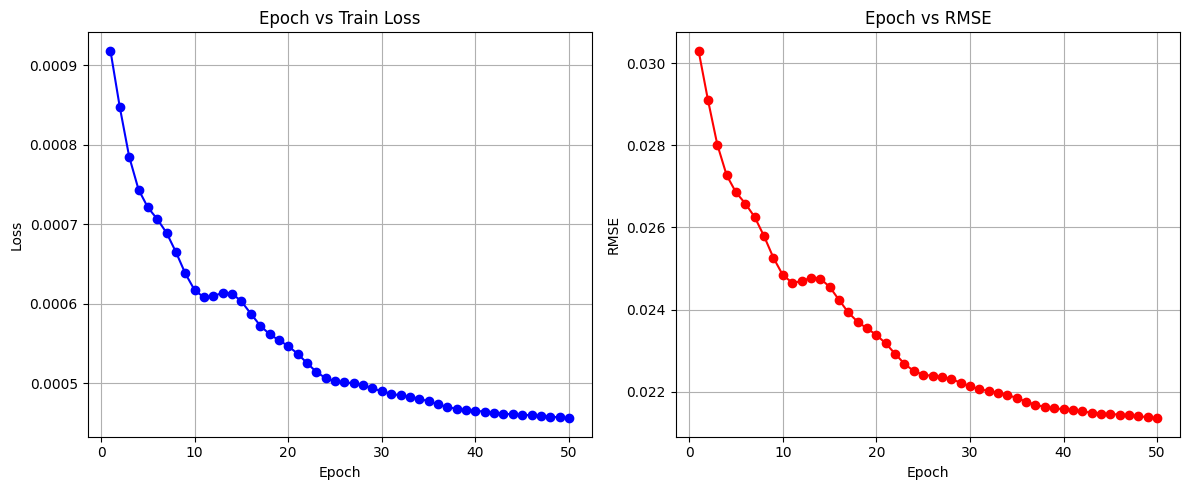

In [10]:
# Definir los parámetros
epochs = num_epochs
train_losses = []
train_rmses = []

# Iterar por cada época y calcular su loss
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # Guardar loss
    train_losses.append(loss.item())
    
    # Calcular RMSE
    rmse = torch.sqrt(loss).item()
    train_rmses.append(rmse)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.6f}, RMSE: {rmse:.6f}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), "lstm_full_model.pth")

# Graficar Epoch vs Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, marker='o', color='blue')
plt.title("Epoch vs Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Graficar Epoch vs RMSE
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_rmses, marker='o', color='red')
plt.title("Epoch vs RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Get min and max of Close from training data (used in MinMax scaling)
close_min = train_df['Close'].min()
close_max = train_df['Close'].max()

# Inverse transform predictions
y_pred_train_inv = y_pred_train * (close_max - close_min) + close_min
y_pred_test_inv  = y_pred_test  * (close_max - close_min) + close_min

# Also inverse-transform true y_test for plotting
y_test_inv = y_test.numpy() * (close_max - close_min) + close_min

In [12]:
# Metrics
rmse = np.sqrt(mean_squared_error(y_test.numpy(), y_pred_test))
mae = mean_absolute_error(y_test.numpy(), y_pred_test)
mape = np.mean(np.abs((y_test.numpy() - y_pred_test) / y_test.numpy())) * 100

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 0.0581
MAE: 0.0427
MAPE: 3.52%


After reverting the scaling applied, our model obtained pretty good metrics overall. 

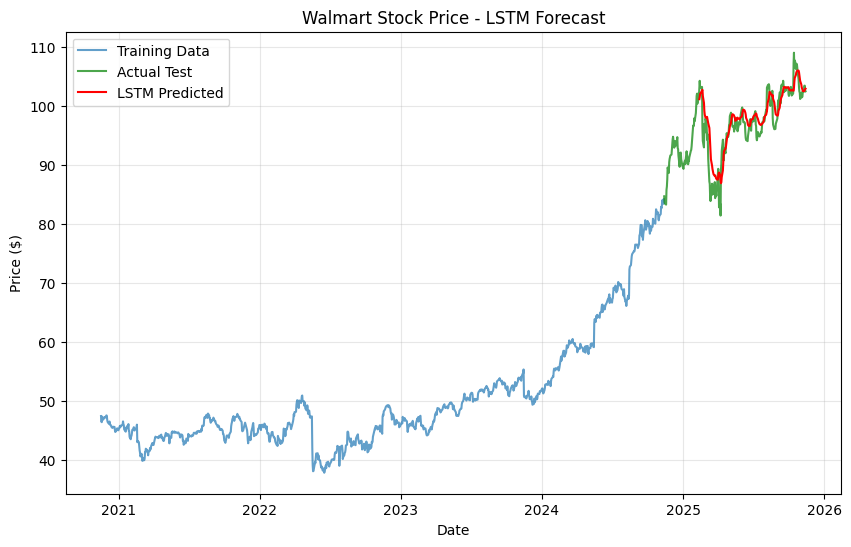

In [13]:
# Results dataframe
lstm_results = test_df.iloc[sequence_length+prediction_horizon-1:].copy()
lstm_results['LSTM_Predicted'] = y_pred_test_inv.flatten()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['Close'], label='Training Data', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Test', alpha=0.7, color='green')
plt.plot(lstm_results.index, lstm_results['LSTM_Predicted'], label='LSTM Predicted', color='red')
plt.title("Walmart Stock Price - LSTM Forecast")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Now, the residual analysis

Text(0.5, 1.0, 'ACF')

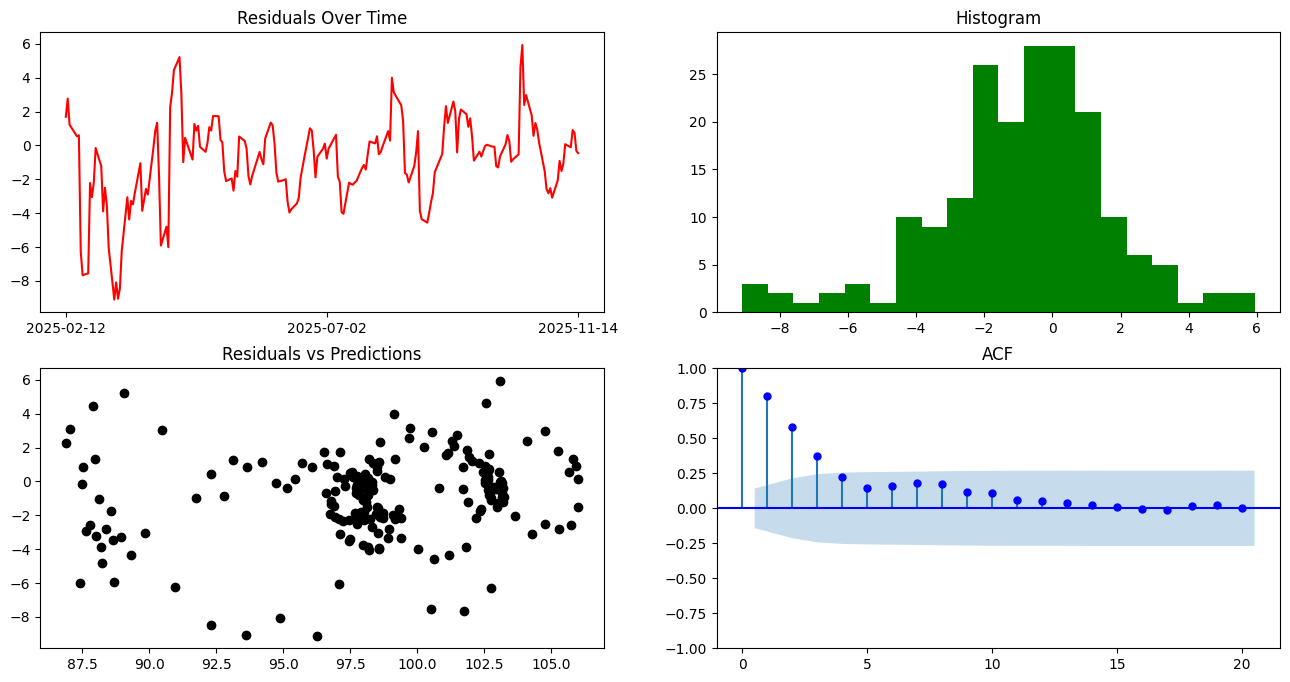

In [14]:
# Calculating residuals
lstm_results['LSTM_Residuals'] = lstm_results['Close'] - lstm_results['LSTM_Predicted']

fig, axes = plt.subplots(2,2, figsize=(16,8))

axes[0,0].plot(lstm_results.index, lstm_results['LSTM_Residuals'], color='red')
axes[0,0].set_title('Residuals Over Time')
graph_1_ticks = [lstm_results.index[0], lstm_results.index[len(lstm_results)//2], lstm_results.index[-1]]
axes[0,0].set_xticks(graph_1_ticks)

axes[0,1].hist(lstm_results['LSTM_Residuals'], bins=20, color='green')
axes[0,1].set_title('Histogram')

axes[1,0].scatter(lstm_results['LSTM_Predicted'], lstm_results['LSTM_Residuals'], color='black')
axes[1,0].set_title('Residuals vs Predictions')

plot_acf(lstm_results['LSTM_Residuals'], lags=20, ax=axes[1,1], color='blue')
axes[1,1].set_title('ACF')

Further inspecting the predictions made in the visualization above, it's clear that the model managed to capture the trends in the data and provides great outputs. 

The Residual Analysis is also very solid. Now, the majority of residuals are between -2 and 2. The ACF chart also only has a couple of lags outside the confidence band, which tells us that the model was able to learn the stock's trend.

# <font color= #bbc28d> **Validation** </font>

The best models obtained were SMA and LSTM. Thus, we will use these two models to validate with new data of Walmart's stocks these last few days, from 15/nov to 19/nov.

In [15]:
# RUN THIS CODE ONLY ONE TIME
start_date = (datetime.now() - timedelta(days=4)).strftime('%Y-%m-%d')          # Gets last 4 days of data
end_date = datetime.now().strftime('%Y-%m-%d')

# Download Walmart prices
wmt = yf.download('WMT', start=start_date, end=end_date, progress=True)

# Flatten columns to get only data
wmt.columns = wmt.columns.get_level_values(0)

# Keep OHLCV data
wmt = wmt[['Open', 'High', 'Low', 'Close', 'Volume']]

# Save to csv
wmt.to_csv('data/walmart_stocks_val.csv', index=True)

C:\Users\Vivienne\AppData\Local\Temp\ipykernel_25476\4276533004.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  wmt = yf.download('WMT', start=start_date, end=end_date, progress=True)
[*********************100%***********************]  1 of 1 completed


In [16]:
# Read data
val_df = pd.read_csv('data/walmart_stocks_val.csv')
val_df['Date'] = pd.to_datetime(val_df['Date'])             # Convert Date column to date type
val_df = val_df.set_index('Date')                           # Make the Date column the index
val_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2025-11-17,102.580002,103.320000,102.099998,102.949997,15289400
2025-11-18,102.980003,103.339996,101.379997,101.389999,17604500
2025-11-19,101.580002,101.709999,99.680000,100.610001,22079700


## <font color= #66b0b0> &ensp; • **MSA** </font>

For MSA, we only used the Closing values for prediction, which we scaled using a MinMaxScaler. Thus, we first have to call the scaler to transform the data:

In [17]:
# Scale validation data
val_df_scaled = scaler.transform(val_df[['Close']])          
val_df_scaled = pd.Series(val_df_scaled.flatten(), index=val_df.index)

For validation data prediction, we're going to build upon the preds made in the test set:

In [22]:
test_pred = sma_results['SMA_Predicted'].values.reshape(-1, 1)

test_pred_scaled = scaler.transform(test_pred).flatten()

history_scaled = np.concatenate([train_df_scaled.values.flatten(), test_pred_scaled])

c:\Users\Vivienne\anaconda3\envs\machine-learning\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [23]:
window_size = 10

# Forecast validation using TRAIN + TEST_PREDICTIONS history
val_preds_scaled = sma_forecast(history_scaled, val_df_scaled, window_size)

# Convert back to original scale
val_preds = scaler.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()

# Store results
sma_val_results = pd.DataFrame({
    'Actual': val_df['Close'].values,
    'SMA_Val_Predicted': val_preds
}, index=val_df.index)

val_rmse = np.sqrt(mean_squared_error(sma_val_results['Actual'], sma_val_results['SMA_Val_Predicted']))
val_mae  = mean_absolute_error(sma_val_results['Actual'], sma_val_results['SMA_Val_Predicted'])
val_mape = mean_absolute_percentage_error(sma_val_results['Actual'], sma_val_results['SMA_Val_Predicted'])

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")
print(f"Validation MAPE: {val_mape*100:.2f}%")

Validation RMSE: 1.3526
Validation MAE:  1.0916
Validation MAPE: 1.08%


We obtained pretty good metrics, let's check the data:

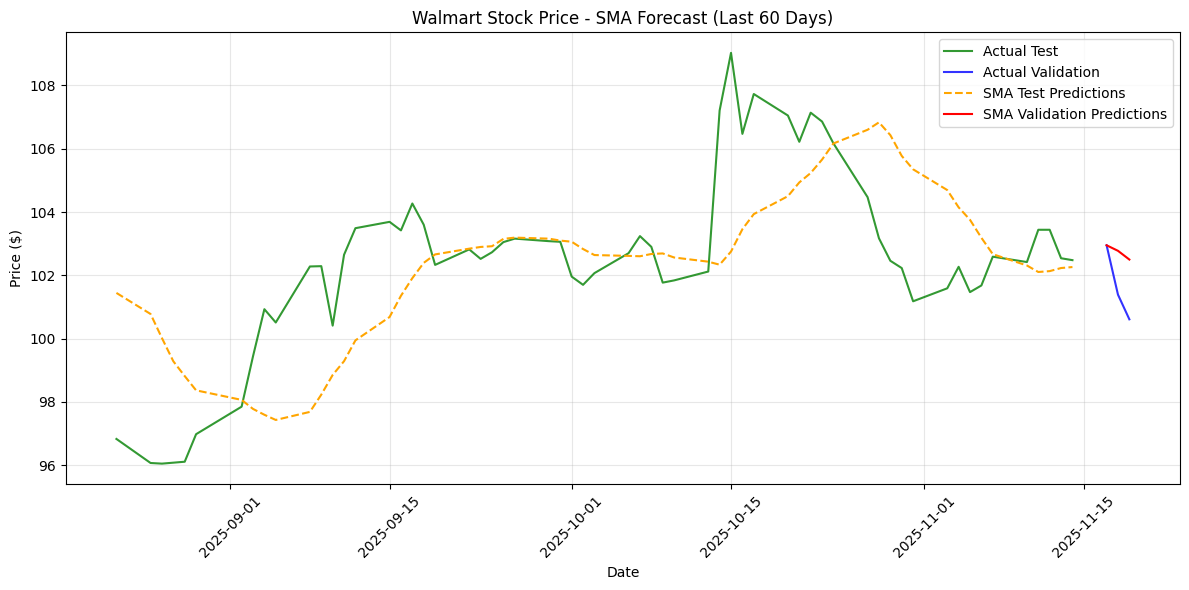

In [25]:
# Zoom to last 60 days of the combined test+val period
zoom_start = test_df.index[-60] if len(test_df) >= 60 else test_df.index[0]
zoom_end = val_df.index[-1]

plt.figure(figsize=(12, 6))

# Actual data
plt.plot(test_df.loc[zoom_start:zoom_end].index, 
         test_df.loc[zoom_start:zoom_end, 'Close'], 
         label='Actual Test', color='green', alpha=0.8)

plt.plot(val_df.loc[zoom_start:zoom_end].index, 
         val_df.loc[zoom_start:zoom_end, 'Close'], 
         label='Actual Validation', color='blue', alpha=0.8)

# Predictions
plt.plot(test_df.loc[zoom_start:zoom_end].index, 
         sma_results.loc[zoom_start:zoom_end, 'SMA_Predicted'], 
         label='SMA Test Predictions', color='orange', linestyle='--')

plt.plot(val_df.loc[zoom_start:zoom_end].index, 
         val_preds, 
         label='SMA Validation Predictions', color='red')

plt.title("Walmart Stock Price - SMA Forecast (Last 60 Days)")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Although the metrics weren't bad, Walmart's stock prices experienced quite a drop in these last few days. Thus, our model has a hard time adjusting. 

## <font color= #66b0b0> &ensp; • **LSTM** </font>

For LSTM, we used all values (OHLCV) and scaled them, so, we're going to apply the same preprocessing to the validation data:

In [26]:
# Scale validation data
X_val_scaled = scaler_all_features.transform(val_df)          
X_val_scaled = pd.DataFrame(X_val_scaled, index=val_df.index, columns=val_df.columns)

Load the LSTM model previously trained:

In [27]:
# Define the model
lstm_model = LSTM(input_size, hidden_size, num_layers)  # provide the same parameters

# Load the saved weights
lstm_model.load_state_dict(torch.load("lstm_full_model.pth"))

# Set the model to evaluation mode
lstm_model.eval()

C:\Users\Vivienne\AppData\Local\Temp\ipykernel_25476\145324304.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("lstm_full_model.pth

LSTM(
  (lstm): LSTM(5, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Same case as with the SMA model, we're going to predict the validation data using the test preds obtained:

In [28]:
history_scaled = pd.concat([X_train_scaled, X_test_scaled])

And then we can proceed to predict the values:

In [29]:
# Make sure model is in eval mode
lstm_model.eval()

val_preds = []

for i in range(len(X_val_scaled)):
    # Take the last `sequence_length` rows
    input_seq = history_scaled.iloc[-sequence_length:].values  # shape: (seq_len, num_features)
    
    # Convert to tensor: (batch_size=1, seq_len, num_features)
    input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
    
    # Predict next Close value
    with torch.no_grad():
        pred = lstm_model(input_tensor).item()
    
    val_preds.append(pred)
    
    # Append actual next validation row to history for recursive prediction
    # (We append all features except Close can be actual or predicted? We'll append actual for features except Close, and predicted for Close)
    next_row = X_val_scaled.iloc[i].copy()
    next_row['Close'] = pred  # replace Close with predicted value
    history_scaled = pd.concat([history_scaled, pd.DataFrame([next_row], index=[X_val_scaled.index[i]])])


In [30]:
# Only invert the Close column
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler_all_features.min_[0], scaler_all_features.scale_[0]

val_preds_inv = close_scaler.inverse_transform(np.array(val_preds).reshape(-1, 1)).flatten()

# Store in DataFrame
lstm_val_results = pd.DataFrame({
    'Actual': val_df['Close'].values,
    'LSTM_Val_Predicted': val_preds_inv
}, index=val_df.index)


In [31]:
lstm_val_results = pd.DataFrame({
    'Actual': val_df['Close'].values,
    'LSTM_Val_Predicted': val_preds_inv
}, index=val_df.index)

# Compute metrics
val_rmse = np.sqrt(mean_squared_error(lstm_val_results['Actual'], lstm_val_results['LSTM_Val_Predicted']))
val_mae  = mean_absolute_error(lstm_val_results['Actual'], lstm_val_results['LSTM_Val_Predicted'])
val_mape = mean_absolute_percentage_error(lstm_val_results['Actual'], lstm_val_results['LSTM_Val_Predicted'])

print(f"LSTM Validation RMSE: {val_rmse:.4f}")
print(f"LSTM Validation MAE:  {val_mae:.4f}")
print(f"LSTM Validation MAPE: {val_mape*100:.2f}%")

LSTM Validation RMSE: 3.6481
LSTM Validation MAE:  3.5494
LSTM Validation MAPE: 3.48%


From the metrics, we can see that the model performance was worse than MSA. 

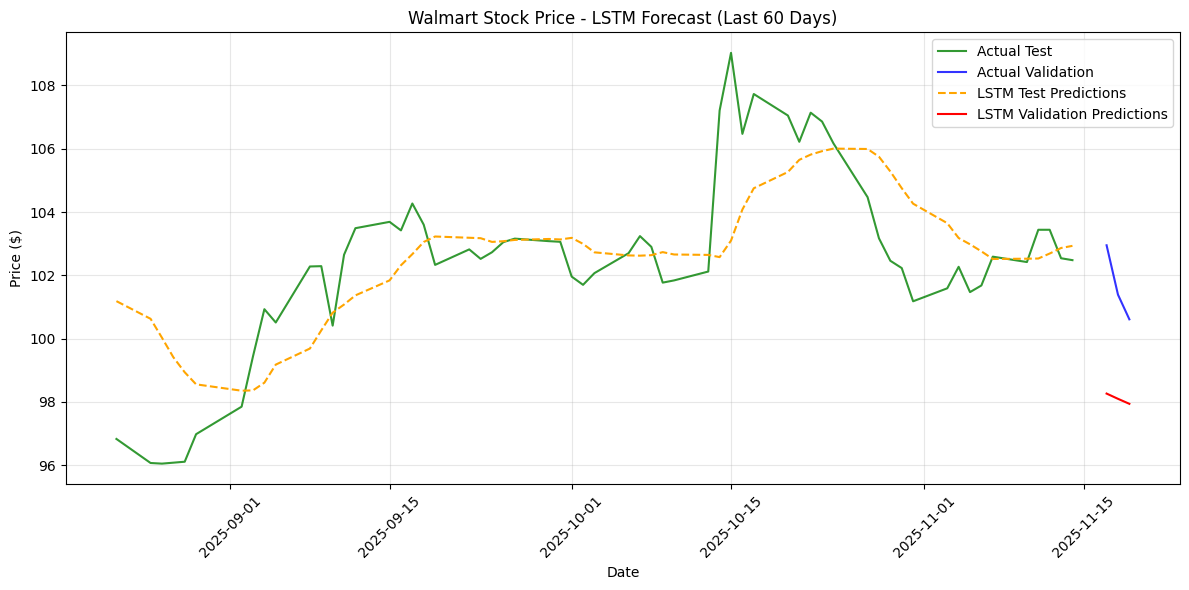

In [32]:
zoom_days = 60
zoom_start = test_df.index[-zoom_days] if len(test_df) >= zoom_days else test_df.index[0]
zoom_end = val_df.index[-1]

plt.figure(figsize=(12, 6))

# Actual Test + Validation
plt.plot(test_df.loc[zoom_start:zoom_end].index, 
         test_df.loc[zoom_start:zoom_end, 'Close'], 
         label='Actual Test', color='green', alpha=0.8)

plt.plot(val_df.loc[zoom_start:zoom_end].index, 
         val_df.loc[zoom_start:zoom_end, 'Close'], 
         label='Actual Validation', color='blue', alpha=0.8)

# LSTM Predictions
# Test predictions first
plt.plot(lstm_results.loc[zoom_start:zoom_end].index, 
         lstm_results.loc[zoom_start:zoom_end, 'LSTM_Predicted'], 
         label='LSTM Test Predictions', color='orange', linestyle='--')

# Validation predictions
plt.plot(val_df.loc[zoom_start:zoom_end].index, 
         lstm_val_results['LSTM_Val_Predicted'], 
         label='LSTM Validation Predictions', color='red')

plt.title("Walmart Stock Price - LSTM Forecast (Last 60 Days)")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

And from the graph, we can clearly see that the predictions were much more hopeful than the actual drop Walmart's stocks experienced in the last few days.

# <font color= #bbc28d> **Bibliography** </font>

- https://pythonfintech.com/articles/plotting-stock-charts-ohlc-matplotlib-mplfinance

- https://www.geeksforgeeks.org/data-analysis/time-series-forecasting-using-pytorch